In [ ]:
from google.colab import userdata

github_token = userdata.get("GITHUB_TOKEN")

# Install the private repository using the token
! pip install nnsight -q
!pip install --upgrade git+https://{github_token}@github.com/withmartian/TinySQL.git

  Cloning https://****@github.com/withmartian/TinySQL.git to /tmp/pip-req-build-5f6ct9a8
  Running command git clone --filter=blob:none --quiet 'https://****@github.com/withmartian/TinySQL.git' /tmp/pip-req-build-5f6ct9a8
  Resolved https://****@github.com/withmartian/TinySQL.git to commit ceaa32dd24973cb67af60fb2de777e78b0453c02
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from TinySQL.load_data.load_model import load_sql_interp_model
device = torch.device('cuda')

tokenizer_sql, model_sql = load_sql_interp_model( model_num=1, cs_num=1, use_flash_attention=False)
#model_sql = model_sql.to(device)


## BM1 CS1: **DefCreateTable**, **EngFieldStart**, **EngFieldSeparator**, **DefFieldSeparator** features

In [ ]:
def is_in_tiny_stories_vocab(word, tokenizer):
    word = word.lower()

    tokens = tokenizer.encode(word, add_special_tokens=False)

    return len(tokens) == 1

words_ts = [
           "select", "show", "pick", "find",
           "pull", "grab", "take", "move", "walk",
           "run", "jump", "stop", "sing", "fly"
       ]

for word in words_ts:
  print(is_in_tiny_stories_vocab(word, tokenizer_sql))

True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
import matplotlib.pyplot as plt
from TinySQL.corrupt_data.clean_corrupt_data import CorruptFeatureTestGenerator

class SimpleSimilarityTester(CorruptFeatureTestGenerator):
   def __init__(self, generate_fn, corruption='EngFieldStart', *args, **kwargs):
       super().__init__(*args, **kwargs)
       self.generate = generate_fn
       self.test_words = [
           "select", "show", "pick", "find",
           "pull", "grab", "take", "move", "walk",
           "run", "jump", "stop", "sing", "fly", 'create'
       ]
       self.test_separators = [
           ",", ";", "&", "|", ":",
           "#", "@", "$", "^", "~",
           "+", "->", "=>", "--", "//", 'and'
       ]
       self.corruption = corruption
   def test_breakdown(self):
       base_item = self._make_base_item()
       base_prompt = base_item.get_alpaca_prompt().replace("show me", "select")
       base_output = self.generate(base_prompt).split()
       results = []

       if self.corruption == 'EngFieldStart':
          print('corrupting EngFieldStart')

          word_similarities = [(word, self.compute_similarity("select", word))
                            for word in self.test_words]
          word_similarities.sort(key=lambda x: x[1])
          for word, similarity in word_similarities:
              corrupted_prompt = base_prompt.replace("select", word)
              corrupt_output = self.generate(corrupted_prompt).split()

              output_similarities = []
              for w1, w2 in zip(base_output, corrupt_output):
                  if w1 == w2:
                      output_similarities.append(1.0)
                  else:
                      output_similarities.append(self.compute_similarity(w1, w2))

              avg_output_similarity = sum(output_similarities) / len(output_similarities) if output_similarities else 0
              results.append((word, avg_output_similarity))


       if self.corruption == 'DefCreateTable':
          print('corrupting DefCreateTable')

          word_similarities = [(word, self.compute_similarity("create", word))
                            for word in self.test_words]
          word_similarities.sort(key=lambda x: x[1])

          for word, similarity in word_similarities:
              corrupted_prompt = base_prompt.replace("CREATE", word.upper())
              corrupt_output = self.generate(corrupted_prompt).split()

              output_similarities = []
              for w1, w2 in zip(base_output, corrupt_output):
                  if w1 == w2:
                      output_similarities.append(1.0)
                  else:
                      output_similarities.append(self.compute_similarity(w1, w2))
              avg_output_similarity = sum(output_similarities) / len(output_similarities) if output_similarities else 0
              results.append((word, avg_output_similarity))

       if self.corruption == 'EngFieldSeparator':
          print('corrupting EngFieldSeparator')

          word_similarities = [(word, self.compute_similarity("and", word))
                            for word in self.test_separators]
          word_similarities.sort(key=lambda x: x[1])
          for word, similarity in word_similarities:
              corrupted_prompt = base_prompt.replace("and", word)
              corrupt_output = self.generate(corrupted_prompt).split()
              output_similarities = []
              for w1, w2 in zip(base_output, corrupt_output):
                  if w1 == w2:
                      output_similarities.append(1.0)
                  else:
                      output_similarities.append(self.compute_similarity(w1, w2))

              avg_output_similarity = sum(output_similarities) / len(output_similarities) if output_similarities else 0
              results.append((word, avg_output_similarity))


       if self.corruption == 'DefFieldSeparator':
          print('corrupting DefFieldSeparator')
          word_similarities = [(word, self.compute_similarity(",", word))
                            for word in self.test_separators]
          word_similarities.sort(key=lambda x: x[1])
          for word, similarity in word_similarities:
              corrupted_prompt = base_prompt.replace(",", word)
              corrupt_output = self.generate(corrupted_prompt).split()

              output_similarities = []
              for w1, w2 in zip(base_output, corrupt_output):
                  if w1 == w2:
                      output_similarities.append(1.0)
                  else:
                      output_similarities.append(self.compute_similarity(w1, w2))

              avg_output_similarity = sum(output_similarities) / len(output_similarities) if output_similarities else 0
              results.append((word, avg_output_similarity))



       self.plot_results(results, word_similarities)
       return results

   def compute_similarity(self, str1: str, str2: str) -> float:
       inputs1 = tokenizer_sql(str1, return_tensors='pt', padding=True).to(model_sql.device)
       inputs2 = tokenizer_sql(str2, return_tensors='pt', padding=True).to(model_sql.device)

       with torch.no_grad():
           embeddings1 = model_sql.transformer(inputs1.input_ids).last_hidden_state.mean(dim=1)
           embeddings2 = model_sql.transformer(inputs2.input_ids).last_hidden_state.mean(dim=1)

       similarity = torch.cosine_similarity(embeddings1, embeddings2)
       return similarity.item()

   def plot_results(self, results, word_similarities):
       output_color = "#8ECAE6"  # Soft blue
       input_color = "#A06CD5"   # Medium purple


       sorted_results = [(w, out_sim) for (w, _), (_, out_sim)
                        in sorted(zip(word_similarities, results),
                                key=lambda x: x[0][1], reverse=True)]

       words, output_sims = zip(*sorted_results)
       input_sims = [sim for _, sim in sorted(word_similarities,
                                            key=lambda x: x[1],
                                            reverse=True)]

       plt.figure(figsize=(12, 6))
       plt.plot(range(len(words)), output_sims, color=output_color, ls='-', marker='o', label='Output Similarity')
       plt.plot(range(len(words)), input_sims, color=input_color, ls='--', marker='s', label='Input Similarity')
       plt.xticks(range(len(words)), words, rotation=45)

       for i, (out_sim, in_sim) in enumerate(zip(output_sims, input_sims)):
           plt.text(i, out_sim, f'{out_sim:.3f}', ha='center', va='bottom', color=output_color)
           plt.text(i, in_sim, f'{in_sim:.3f}', ha='center', va='bottom', color=input_color)

       plt.xlabel(f'{self.corruption} (Ordered by Input Similarity)')
       plt.ylabel('Similarity Score')
       plt.title(f'Model Sensitivity to {self.corruption} Substitution')
       plt.legend()
       plt.grid(True, alpha=0.3)
       plt.tight_layout()
       plt.savefig(f'{self.corruption}_breakdown.png', dpi=300)
       plt.show()

def generate_wrapper(prompt):
   inputs = tokenizer_sql(prompt, return_tensors='pt', padding=True).to(model_sql.device)
   outputs = model_sql.generate(
       inputs.input_ids,
       attention_mask=inputs.attention_mask,
       max_new_tokens=100,
       pad_token_id=tokenizer_sql.eos_token_id,
       do_sample=False
   )
   return tokenizer_sql.decode(outputs[0], skip_special_tokens=True)



corrupting DefCreateTable


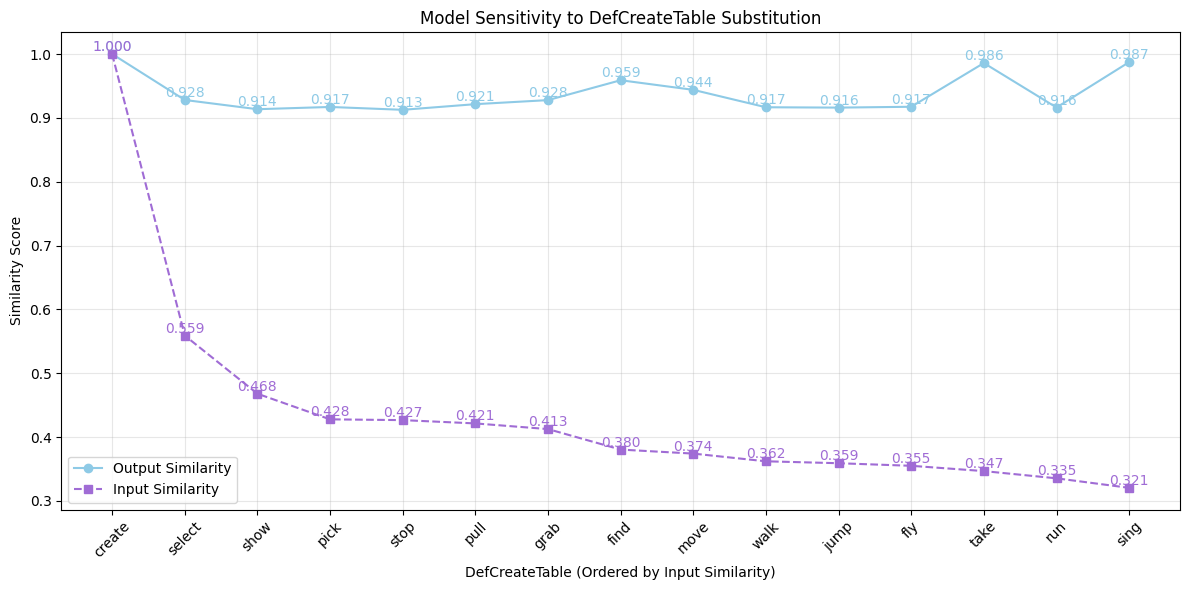

In [ ]:
tester = SimpleSimilarityTester(generate_wrapper, "DefCreateTable")
results = tester.test_breakdown()

corrupting EngFieldStart


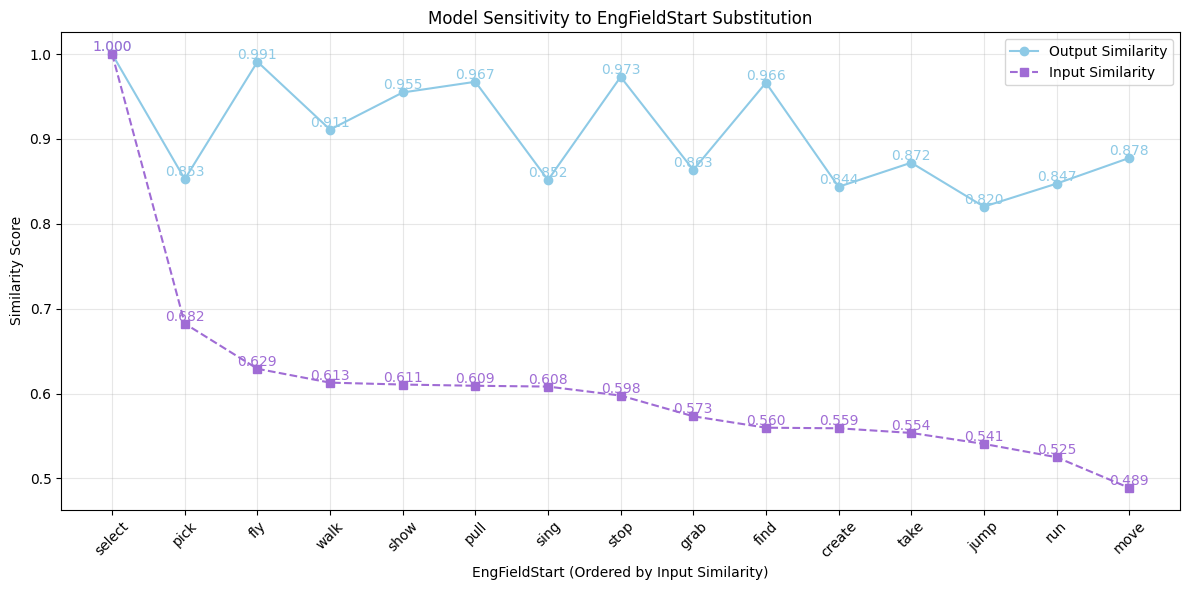

In [ ]:
tester = SimpleSimilarityTester(generate_wrapper, "EngFieldStart")
results = tester.test_breakdown()

corrupting EngFieldSeparator


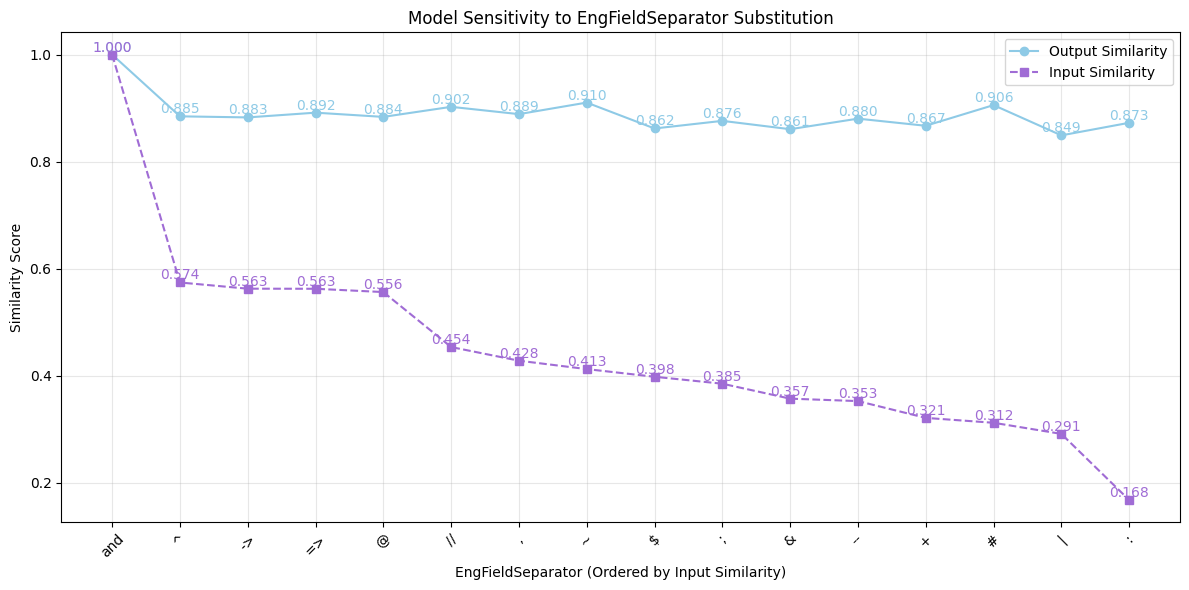

In [ ]:
tester = SimpleSimilarityTester(generate_wrapper, "EngFieldSeparator")
results = tester.test_breakdown()

corrupting DefFieldSeparator


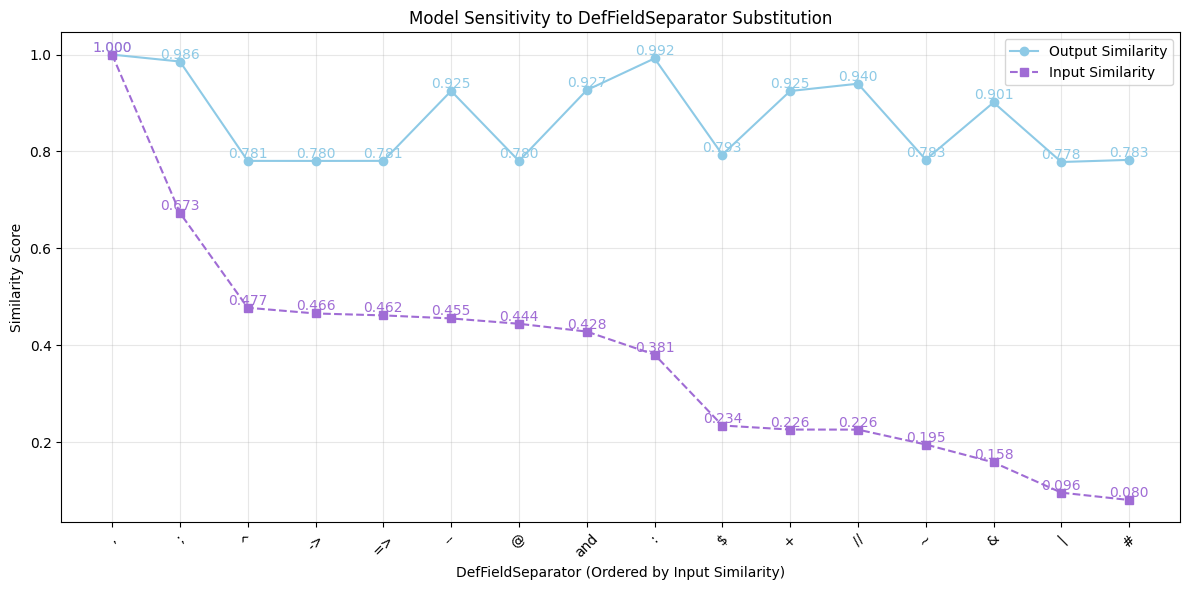

In [ ]:
tester = SimpleSimilarityTester(generate_wrapper, "DefFieldSeparator")
results = tester.test_breakdown()

## BM1 CS1 Duplicate Tokens

### Swap table and field names

In [ ]:
from TinySQL.corrupt_data.clean_corrupt_data import CorruptFeatureTestGenerator as cpt
import random
random.seed(42)
def generate_output(prompt):
  inputs = tokenizer_sql(prompt, return_tensors='pt', padding=True).to(model_sql.device)
  outputs = model_sql.generate(
      inputs.input_ids,
      early_stopping=True,
      pad_token_id=tokenizer_sql.eos_token_id,
      do_sample=False
  )
  return tokenizer_sql.decode(outputs[0], skip_special_tokens=True)

In [ ]:
import re

def swap_field_table_eng_1field(sql_text):

    create_line = [line for line in sql_text.split('\n') if 'CREATE TABLE' in line][0]
    table_name = create_line.split('TABLE')[1].split('(')[0].strip()
    first_field = create_line.split('(')[1].split()[0].strip()

    new_text = sql_text.replace(first_field, "TEMP", 1)
    new_text = new_text.replace(table_name, first_field, 1)
    new_text = new_text.replace("TEMP", table_name, 1)
    return new_text

def swap_field_table_eng_2field(sql_text):
    create_line = [line for line in sql_text.split('\n') if 'CREATE TABLE' in line][0]
    table_name = create_line.split('TABLE')[1].split('(')[0].strip()
    fields = create_line.split('(')[1].split(',')
    second_field = fields[1].split()[0].strip()

    new_text = sql_text.replace(second_field, "TEMP", 1)
    new_text = new_text.replace(table_name, second_field, 1)
    new_text = new_text.replace("TEMP", table_name, 1)
    return new_text

def swap_field_table_create_1field(sql_text):
    sections = sql_text.split('###')

    new_sections = []
    for section in sections:
        if section and 'Context' in section:
            create_line = [line for line in section.split('\n') if 'CREATE TABLE' in line][0]

            table_name = create_line.split('TABLE')[1].split('(')[0].strip()
            first_field = create_line.split('(')[1].split()[0].strip()

            new_create = create_line.replace(table_name, "TEMP", 1)
            new_create = new_create.replace(first_field, table_name, 1)
            new_create = new_create.replace("TEMP", first_field, 1)

            section = section.replace(create_line, new_create)

        new_sections.append(section)

    return '###'.join(new_sections)

def swap_field_table_create_2field(sql_text):
    sections = sql_text.split('###')

    new_sections = []
    for section in sections:
        if section and 'Context' in section:
            create_line = [line for line in section.split('\n') if 'CREATE TABLE' in line][0]

            table_name = create_line.split('TABLE')[1].split('(')[0].strip()
            fields = create_line.split('(')[1].split(',')
            second_field = fields[1].split()[0].strip()

            new_create = create_line.replace(table_name, "TEMP", 1)
            new_create = new_create.replace(second_field, table_name, 1)
            new_create = new_create.replace("TEMP", second_field, 1)

            section = section.replace(create_line, new_create)

        new_sections.append(section)

    return '###'.join(new_sections)


def extract_parts(text):
    # Part 1: Get everything between first "### Response:" and "("
    pattern1 = r'### Response:(.*?)\('
    part1 = re.search(pattern1, text, re.DOTALL).group(1)

    # Part 2: Get the complete CREATE TABLE statement up to the second ### Response
    pattern2 = r'### Response:(.*?)### Response:'
    part2 = re.search(pattern2, text, re.DOTALL).group(1)

    # Part 3: Get everything after second "### Response:"
    pattern3 = r'### Response:.*?### Response:(.*)'
    part3 = re.search(pattern3, text, re.DOTALL).group(1)

    return part1.strip(), part2.strip(), part3.strip()

def similarity(base_output, corrupt_output):

  def _compute_similarity(str1, str2):
    inputs1 = tokenizer_sql(str1, return_tensors='pt', padding=True).to(model_sql.device)
    inputs2 = tokenizer_sql(str2, return_tensors='pt', padding=True).to(model_sql.device)

    with torch.no_grad():
        embeddings1 = model_sql.transformer(inputs1.input_ids).last_hidden_state.mean(dim=1)
        embeddings2 = model_sql.transformer(inputs2.input_ids).last_hidden_state.mean(dim=1)

    similarity = torch.cosine_similarity(embeddings1, embeddings2)
    return similarity.item()

  output_similarities = []
  for w1, w2 in zip(base_output, corrupt_output):
      if w1 == w2:
          output_similarities.append(1.0)
      else:
          output_similarities.append(_compute_similarity(w1, w2))

  avg_output_similarity = sum(output_similarities) / len(output_similarities) if output_similarities else 0

  return avg_output_similarity


In [ ]:
base_item = cpt(1)._make_base_item()
base_prompt = base_item.get_alpaca_prompt()
base_output = generate_output(base_prompt)
base_output

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


'### Instruction:\nshow me the price and amount from the cost table\n### Context:\nCREATE TABLE cost ( price CHAR, amount CHAR )\n### Response:\nCREATE TABLE cost (\n    amount DECIMAL(10,2),\n '

In [ ]:
text = base_prompt
result = swap_field_table_eng_2field(text) #.replace('TABLE people', 'TABLE abir')
base_output_swap = generate_output(result)
base_output_swap

'### Instruction:\nshow me the price and cost from the amount table\n### Context:\nCREATE TABLE cost ( price CHAR, amount CHAR )\n### Response:\nCREATE TABLE amount (\n    price DECIMAL(10,2),\n '

In [ ]:
from tqdm import tqdm

def compute_average_similarities(n_iterations):
    total_similarities = {
        'SwapEng2': {'Part 1': 0.0, 'Part 2': 0.0, 'Part 3': 0.0},
        'SwapEng1': {'Part 1': 0.0, 'Part 2': 0.0, 'Part 3': 0.0},
        'SwapCreate1': {'Part 1': 0.0, 'Part 2': 0.0, 'Part 3': 0.0},
        'SwapCreate2': {'Part 1': 0.0, 'Part 2': 0.0, 'Part 3': 0.0}
    }

    swap_functions = {
        'SwapEng2': swap_field_table_eng_2field,
        'SwapEng1': swap_field_table_eng_1field,
        'SwapCreate1': swap_field_table_create_1field,
        'SwapCreate2': swap_field_table_create_2field
    }

    for i in tqdm(range(n_iterations)):
        base_item = cpt(i)._make_base_item()
        base_prompt = base_item.get_alpaca_prompt()
        base_output = generate_output(base_prompt)
        base_parts = extract_parts(base_output)

        for name, func in swap_functions.items():
            result = func(base_prompt)
            swapped_output = generate_output(result)
            swapped_parts = extract_parts(swapped_output)

            for j in range(3):
                total_similarities[name][f'Part {j+1}'] += similarity(base_parts[j], swapped_parts[j])

    average_similarities = {}
    for name in swap_functions.keys():
        average_similarities[name] = {
            part: score / n_iterations
            for part, score in total_similarities[name].items()
        }

    return average_similarities

iterations = 10
avg_sims = compute_average_similarities(iterations)
print(f"Average similarities over {iterations} iterations:")
print(avg_sims)

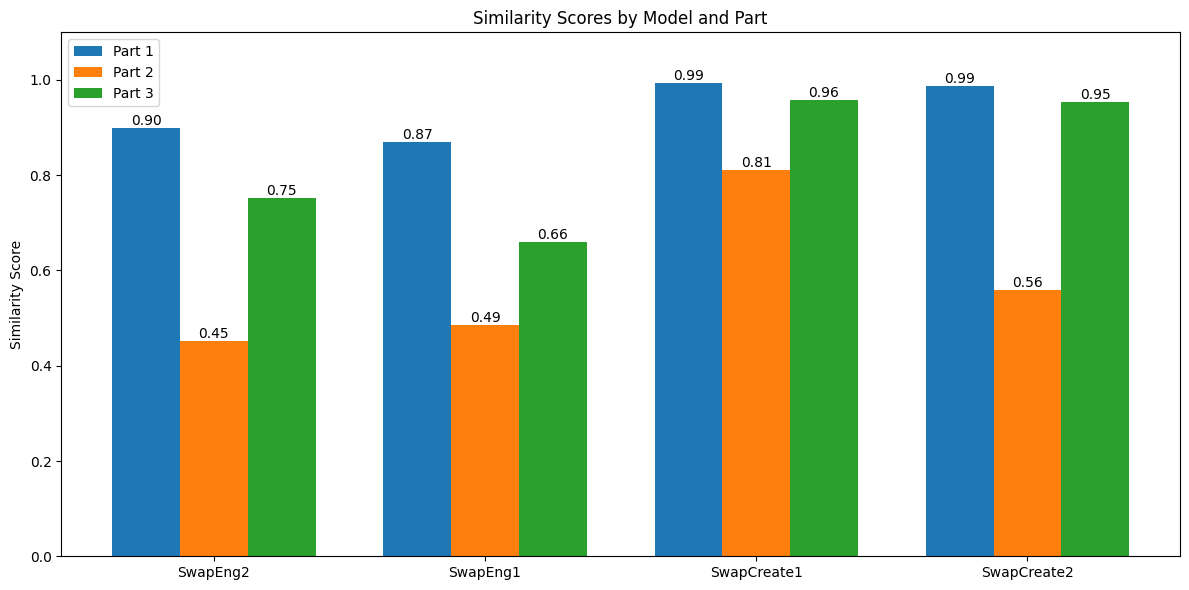

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_similarities(similarities):
    models = list(similarities.keys())
    parts = ['Part 1', 'Part 2', 'Part 3']

    x = np.arange(len(models))
    width = 0.25

    fig, ax = plt.subplots(figsize=(12, 6))

    bars1 = ax.bar(x - width, [similarities[m]['Part 1'] for m in models], width, label='Part 1')
    bars2 = ax.bar(x, [similarities[m]['Part 2'] for m in models], width, label='Part 2')
    bars3 = ax.bar(x + width, [similarities[m]['Part 3'] for m in models], width, label='Part 3')

    ax.set_ylabel('Similarity Score')
    ax.set_title('Similarity Scores by Model and Part')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()
    ax.set_ylim(0, 1.1)

    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}',
                   ha='center', va='bottom')

    plt.tight_layout()
    return plt


plt = plot_similarities(avg_sims)
plt.savefig('similarity_scores.png', dpi=300)
plt.show()

In [ ]:
import re

def extract_all_elements(text):
    # Extract from instruction
    instruction_table_pattern = r'from the (\w+) table'
    instruction_fields_pattern = r'show me the (\w+) and (\w+) from'
    instruction_table = re.search(instruction_table_pattern, text).group(1)
    instruction_fields = re.search(instruction_fields_pattern, text).groups()

    # Extract from context CREATE TABLE
    context_pattern = r'CREATE TABLE (\w+) \( (\w+) \w+, (\w+) \w+ \)'
    context_match = re.search(context_pattern, text)
    context_table = context_match.group(1)
    context_fields = [context_match.group(2), context_match.group(3)]

    # Extract from Response CREATE TABLE (if exists)
    response_create_pattern = r'### Response:\nCREATE TABLE (\w+)'
    response_table = None
    try:
        response_table = re.search(response_create_pattern, text).group(1)
    except AttributeError:
        pass

    # Extract from Response SELECT (if exists)
    select_pattern = r'FROM (\w+)'
    select_fields_pattern = r'SELECT\s+(\w+),\s+(\w+)'
    response_select_table = None
    response_select_fields = None
    try:
        response_select_table = re.search(select_pattern, text).group(1)
        response_select_fields = re.search(select_fields_pattern, text).groups()
    except AttributeError:
        pass

    return {
        'instruction': {
            'table': instruction_table,
            'fields': instruction_fields
        },
        'context': {
            'table': context_table,
            'fields': context_fields
        },
        'response_create': {
            'table': response_table
        },
        'response_select': {
            'table': response_select_table,
            'fields': response_select_fields
        }
    }


result2 = extract_all_elements(swapped_output)
result2

{'instruction': {'table': 'people', 'fields': ('count', 'name')},
 'context': {'table': 'count', 'fields': ['people', 'name']},
 'response_create': {'table': 'people'},
 'response_select': {'table': 'count', 'fields': ('count', 'name')}}

In [ ]:
from tqdm import tqdm

def sims_table(n_iterations):
    total_similarities = {
        'SwapEng2': {'table_inst_vs_create': 0.0, 'table_inst_vs_select': 0.0, 'table_ctx_vs_select': 0.0, 'table_ctx_vs_create': 0.0},
        'SwapEng1': {'table_inst_vs_create': 0.0, 'table_inst_vs_select': 0.0, 'table_ctx_vs_select': 0.0, 'table_ctx_vs_create': 0.0},
        'SwapCreate1': {'table_inst_vs_create': 0.0, 'table_inst_vs_select': 0.0, 'table_ctx_vs_select': 0.0, 'table_ctx_vs_create': 0.0},
        'SwapCreate2': {'table_inst_vs_create': 0.0, 'table_inst_vs_select': 0.0, 'table_ctx_vs_select': 0.0, 'table_ctx_vs_create': 0.0}
    }

    successful_iterations = {
        'SwapEng2': {'table_inst_vs_create': 0, 'table_inst_vs_select': 0, 'table_ctx_vs_select': 0, 'table_ctx_vs_create': 0},
        'SwapEng1': {'table_inst_vs_create': 0, 'table_inst_vs_select': 0, 'table_ctx_vs_select': 0, 'table_ctx_vs_create': 0},
        'SwapCreate1': {'table_inst_vs_create': 0, 'table_inst_vs_select': 0, 'table_ctx_vs_select': 0, 'table_ctx_vs_create': 0},
        'SwapCreate2': {'table_inst_vs_create': 0, 'table_inst_vs_select': 0, 'table_ctx_vs_select': 0, 'table_ctx_vs_create': 0}
    }

    swap_functions = {
        'SwapEng2': swap_field_table_eng_2field,
        'SwapEng1': swap_field_table_eng_1field,
        'SwapCreate1': swap_field_table_create_1field,
        'SwapCreate2': swap_field_table_create_2field
    }

    for i in tqdm(range(n_iterations)):
        try:
            base_item = cpt(i)._make_base_item()
            base_prompt = base_item.get_alpaca_prompt()
            base_output = generate_output(base_prompt)

            for name, func in swap_functions.items():
                try:
                    result = func(base_prompt)
                    swapped_output = generate_output(result)
                    swapped_parts = extract_all_elements(swapped_output)

                    # Only add similarity if both elements exist
                    if swapped_parts["instruction"]['table'] is not None and swapped_parts["response_create"]['table'] is not None:
                        total_similarities[name]['table_inst_vs_create'] += similarity(swapped_parts["instruction"]['table'], swapped_parts["response_create"]['table'])
                        successful_iterations[name]['table_inst_vs_create'] += 1

                    if swapped_parts["instruction"]['table'] is not None and swapped_parts["response_select"]['table'] is not None:
                        total_similarities[name]['table_inst_vs_select'] += similarity(swapped_parts["instruction"]['table'], swapped_parts["response_select"]['table'])
                        successful_iterations[name]['table_inst_vs_select'] += 1

                    if swapped_parts["context"]['table'] is not None and swapped_parts["response_select"]['table'] is not None:
                        total_similarities[name]['table_ctx_vs_select'] += similarity(swapped_parts["context"]['table'], swapped_parts["response_select"]['table'])
                        successful_iterations[name]['table_ctx_vs_select'] += 1

                    if swapped_parts["context"]['table'] is not None and swapped_parts["response_create"]['table'] is not None:
                        total_similarities[name]['table_ctx_vs_create'] += similarity(swapped_parts["context"]['table'], swapped_parts["response_create"]['table'])
                        successful_iterations[name]['table_ctx_vs_create'] += 1

                except Exception as e:
                    print(f"Error in swap function {name}: {e}")
                    continue

        except Exception as e:
            print(f"Error in iteration {i}: {e}")
            continue

    average_similarities = {}
    for name in swap_functions.keys():
        average_similarities[name] = {
            part: (total_similarities[name][part] / successful_iterations[name][part])
            if successful_iterations[name][part] > 0 else 0.0
            for part in total_similarities[name]
        }

    return average_similarities

iterations = 50
avg_sims_table = sims_table(iterations)
print(f"Average similarities over {iterations} iterations:")
print(avg_sims_table)

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
100%|██████████| 50/50 [02:18<00:00,  2.76s/it]

Average similarities over 50 iterations:
{'SwapEng2': {'table_inst_vs_create': 0.860193307042122, 'table_inst_vs_select': 0.6702004256546499, 'table_ctx_vs_select': 0.8849915142059325, 'table_ctx_vs_create': 0.6949986328184607}, 'SwapEng1': {'table_inst_vs_create': 0.7899279165632872, 'table_inst_vs_select': 0.6871527317464353, 'table_ctx_vs_select': 0.851816719988982, 'table_ctx_vs_create': 0.7493088916957787}, 'SwapCreate1': {'table_inst_vs_create': 0.97951810836792, 'table_inst_vs_select': 0.7550109574496747, 'table_ctx_vs_select': 0.7733692313432695, 'table_ctx_vs_create': 0.5594513433674974}, 'SwapCreate2': {'table_inst_vs_create': 0.9495856109261512, 'table_inst_vs_select': 0.7669193963408472, 'table_ctx_vs_select': 0.7882725435197355, 'table_ctx_vs_create': 0.6056063289344312}}


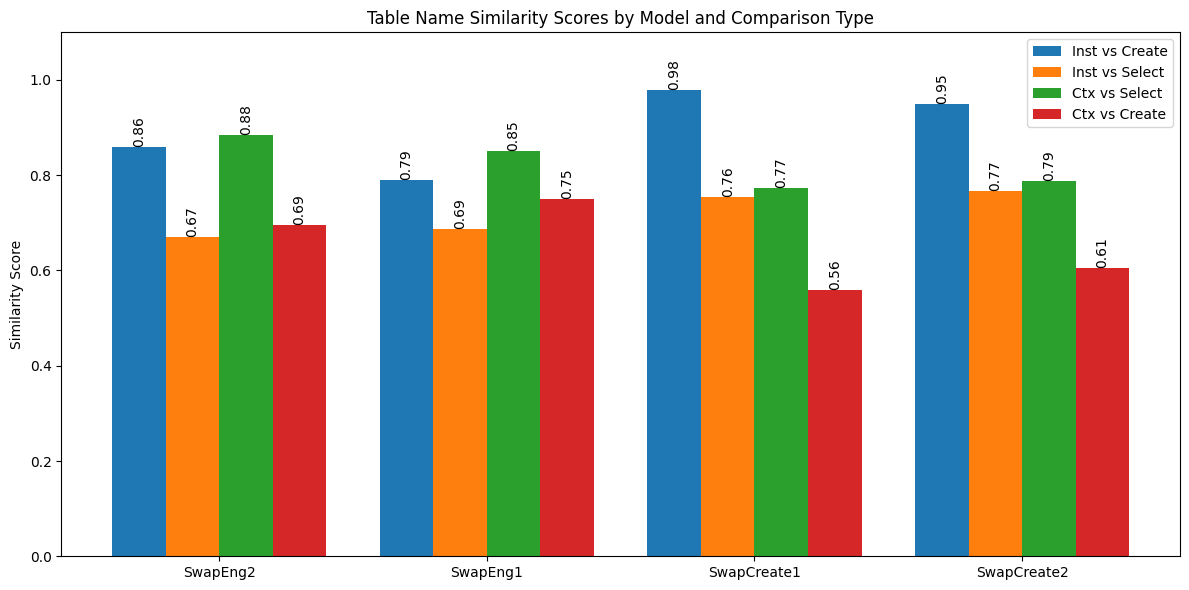

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_table_similarities(similarities):
    models = list(similarities.keys())
    metrics = ['table_inst_vs_create', 'table_inst_vs_select',
               'table_ctx_vs_select', 'table_ctx_vs_create']

    x = np.arange(len(models))
    width = 0.2

    fig, ax = plt.subplots(figsize=(12, 6))

    bars1 = ax.bar(x - width*1.5, [similarities[m]['table_inst_vs_create'] for m in models],
                   width, label='Inst vs Create')
    bars2 = ax.bar(x - width/2, [similarities[m]['table_inst_vs_select'] for m in models],
                   width, label='Inst vs Select')
    bars3 = ax.bar(x + width/2, [similarities[m]['table_ctx_vs_select'] for m in models],
                   width, label='Ctx vs Select')
    bars4 = ax.bar(x + width*1.5, [similarities[m]['table_ctx_vs_create'] for m in models],
                   width, label='Ctx vs Create')

    ax.set_ylabel('Similarity Score')
    ax.set_title('Table Name Similarity Scores by Model and Comparison Type')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()
    ax.set_ylim(0, 1.1)

    for bars in [bars1, bars2, bars3, bars4]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}',
                   ha='center', va='bottom', rotation=90)

    plt.tight_layout()
    return plt

plt = plot_table_similarities(avg_sims_table)
plt.savefig('table_similarity_scores.png', dpi=300)
plt.show()

In [ ]:
from tqdm import tqdm

def sims_fields(n_iterations):
    total_similarities = {
        'SwapEng2': {'Field1_resp_int': 0.0, 'Field1_resp_ctx': 0.0, 'Field2_resp_int': 0.0, 'Field2_resp_ctx': 0.0},
        'SwapEng1': {'Field1_resp_int': 0.0, 'Field1_resp_ctx': 0.0, 'Field2_resp_int': 0.0, 'Field2_resp_ctx': 0.0},
        'SwapCreate1': {'Field1_resp_int': 0.0, 'Field1_resp_ctx': 0.0, 'Field2_resp_int': 0.0, 'Field2_resp_ctx': 0.0},
        'SwapCreate2': {'Field1_resp_int': 0.0, 'Field1_resp_ctx': 0.0, 'Field2_resp_int': 0.0, 'Field2_resp_ctx': 0.0}
    }

    successful_iterations = {
        'SwapEng2': {'Field1_resp_int': 0.0, 'Field1_resp_ctx': 0.0, 'Field2_resp_int': 0.0, 'Field2_resp_ctx': 0.0},
        'SwapEng1': {'Field1_resp_int': 0.0, 'Field1_resp_ctx': 0.0, 'Field2_resp_int': 0.0, 'Field2_resp_ctx': 0.0},
        'SwapCreate1': {'Field1_resp_int': 0.0, 'Field1_resp_ctx': 0.0, 'Field2_resp_int': 0.0, 'Field2_resp_ctx': 0.0},
        'SwapCreate2': {'Field1_resp_int': 0.0, 'Field1_resp_ctx': 0.0, 'Field2_resp_int': 0.0, 'Field2_resp_ctx': 0.0}
    }

    swap_functions = {
        'SwapEng2': swap_field_table_eng_2field,
        'SwapEng1': swap_field_table_eng_1field,
        'SwapCreate1': swap_field_table_create_1field,
        'SwapCreate2': swap_field_table_create_2field
    }

    for i in tqdm(range(n_iterations)):
        try:
            base_item = cpt(i)._make_base_item()
            base_prompt = base_item.get_alpaca_prompt()
            base_output = generate_output(base_prompt)

            for name, func in swap_functions.items():
                try:
                    result = func(base_prompt)
                    swapped_output = generate_output(result)
                    swapped_parts = extract_all_elements(swapped_output)

                    # Only add similarity if both elements exist
                    if swapped_parts["instruction"]['fields'] is not None and swapped_parts["response_select"]['fields'] is not None:
                        total_similarities[name]['Field1_resp_int'] += similarity(swapped_parts["instruction"]['fields'][0], swapped_parts["response_select"]['fields'][0])
                        total_similarities[name]['Field2_resp_int'] += similarity(swapped_parts["instruction"]['fields'][1], swapped_parts["response_select"]['fields'][1])
                        successful_iterations[name]['Field1_resp_int'] += 1
                        successful_iterations[name]['Field2_resp_int'] += 1


                    if swapped_parts["context"]['fields'] is not None and swapped_parts["response_select"]['fields'] is not None:
                        total_similarities[name]['Field1_resp_ctx'] += similarity(swapped_parts["context"]['fields'][0], swapped_parts["response_select"]['fields'][0])
                        total_similarities[name]['Field2_resp_ctx'] += similarity(swapped_parts["context"]['fields'][1], swapped_parts["response_select"]['fields'][1])
                        successful_iterations[name]['Field2_resp_ctx'] += 1
                        successful_iterations[name]['Field1_resp_ctx'] += 1



                except Exception as e:
                    print(f"Error in swap function {name}: {e}")
                    continue

        except Exception as e:
            print(f"Error in iteration {i}: {e}")
            continue

    average_similarities = {}
    for name in swap_functions.keys():
        average_similarities[name] = {
            part: (total_similarities[name][part] / successful_iterations[name][part])
            if successful_iterations[name][part] > 0 else 0.0
            for part in total_similarities[name]
        }

    return average_similarities

iterations = 50
avg_sim_field = sims_fields(iterations)
print(f"Average similarities over {iterations} iterations:")
print(avg_sim_field)

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
100%|██████████| 50/50 [02:16<00:00,  2.74s/it]

Average similarities over 50 iterations:
{'SwapEng2': {'Field1_resp_int': 1.0, 'Field1_resp_ctx': 1.0, 'Field2_resp_int': 0.8788912604401509, 'Field2_resp_ctx': 0.542744027942419}, 'SwapEng1': {'Field1_resp_int': 0.9578432669794118, 'Field1_resp_ctx': 0.6123280723889669, 'Field2_resp_int': 1.0, 'Field2_resp_ctx': 1.0}, 'SwapCreate1': {'Field1_resp_int': 1.0, 'Field1_resp_ctx': 0.5662699837386609, 'Field2_resp_int': 1.0, 'Field2_resp_ctx': 1.0}, 'SwapCreate2': {'Field1_resp_int': 1.0, 'Field1_resp_ctx': 1.0, 'Field2_resp_int': 1.0, 'Field2_resp_ctx': 0.5752029849787554}}


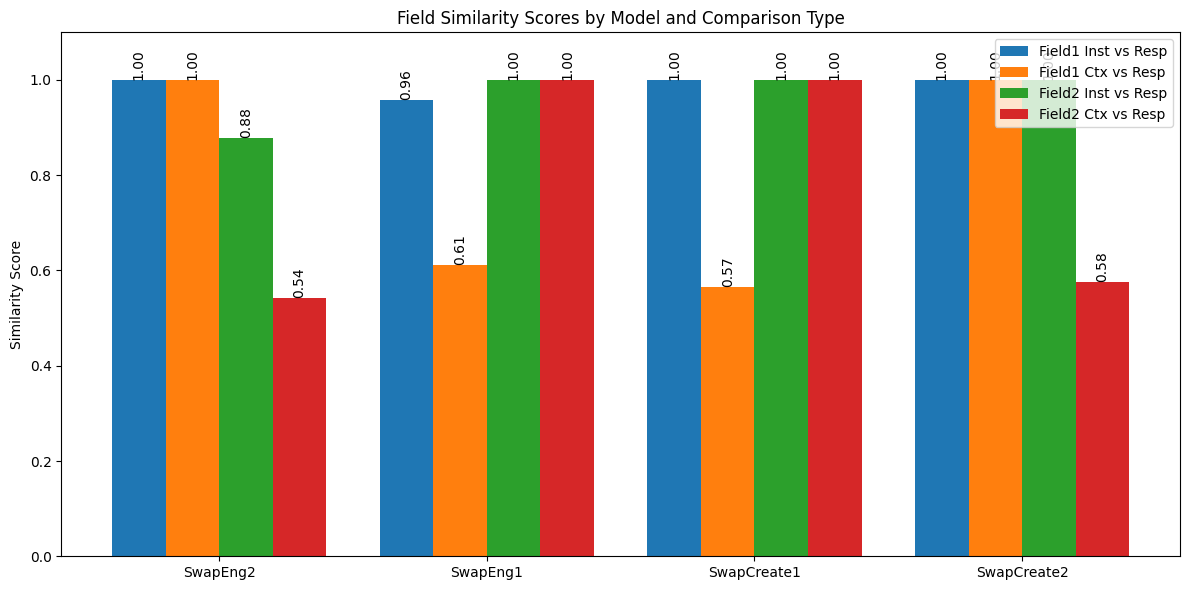

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_field_similarities(similarities):
    models = list(similarities.keys())
    metrics = ['Field1_resp_int', 'Field1_resp_ctx', 'Field2_resp_int', 'Field2_resp_ctx']

    x = np.arange(len(models))
    width = 0.2

    fig, ax = plt.subplots(figsize=(12, 6))

    bars1 = ax.bar(x - width*1.5, [similarities[m]['Field1_resp_int'] for m in models],
                   width, label='Field1 Inst vs Resp')
    bars2 = ax.bar(x - width/2, [similarities[m]['Field1_resp_ctx'] for m in models],
                   width, label='Field1 Ctx vs Resp')
    bars3 = ax.bar(x + width/2, [similarities[m]['Field2_resp_int'] for m in models],
                   width, label='Field2 Inst vs Resp')
    bars4 = ax.bar(x + width*1.5, [similarities[m]['Field2_resp_ctx'] for m in models],
                   width, label='Field2 Ctx vs Resp')

    ax.set_ylabel('Similarity Score')
    ax.set_title('Field Similarity Scores by Model and Comparison Type')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()
    ax.set_ylim(0, 1.1)

    for bars in [bars1, bars2, bars3, bars4]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}',
                   ha='center', va='bottom', rotation=90)

    plt.tight_layout()
    return plt


plt = plot_field_similarities(avg_sim_field)
plt.savefig('field_similarity_scores.png', dpi=300)
plt.show()

### Insignificant tokens -> Random words

In [ ]:
def replace_sql_words(text):
    # Extract the part between ### Instruction: and ### Context:
    instruction_start = text.find('### Instruction:') + len('### Instruction:')
    context_start = text.find('### Context:')
    instruction = text[instruction_start:context_start]

    # Dictionary of replacements
    replacements = {
        'select': 'rose',
        'the': 'hit',
        'and': 'under',
        'from': 'sky',
        'table': 'one'
    }

    # Replace words
    new_instruction = instruction
    for old_word, new_word in replacements.items():
        new_instruction = new_instruction.replace(old_word, new_word)

    # Put text back together
    return text[:instruction_start] + new_instruction + text[context_start:]

# Test it
text = """### Instruction:
select the id and amount from the cost table
### Context:
CREATE TABLE cost ( id TIME, amount CHAR )
### Response:
"""
result = replace_sql_words(text)
base_output_rd = generate_output(result)
base_output_rd

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


'### Instruction:\nrose hit id under amount sky hit cost one\n### Context:\nCREATE TABLE cost ( id TIME, amount CHAR )\n### Response:\nCREATE TABLE cost (\n    id SERIAL,\n    last_login TIMESTAMP,\n    is_published BOOLEAN,\n    end_date DATE,\n    cost DECIMAL(10,2),\n    blog_id INTEGER,\n    blog_id INTEGER,\n    subject VARCHAR(255),\n    meta_keywords VARCHAR(500),\n    end_time TIME\n)\n### Response:\nSELECT\n    id\nFROM cost'

### Corrupt DefTableName, DefFieldName

In [ ]:
base_item = cpt(1)._make_base_item()
base_prompt = base_item.get_alpaca_prompt()
base_output = generate_output(base_prompt)
base_output

'### Instruction:\nshow me the price and name from the people table\n### Context:\nCREATE TABLE people ( price INT, name JSON )\n### Response:\nCREATE TABLE people (\n    name VARCHAR(255),\n    name VARCHAR(255),\n    price DECIMAL(10,2),\n    name VARCHAR(255),\n    is_deleted TINYINT(1),\n    end_time TIME,\n    views INTEGER,\n    mobile VARCHAR(20),\n    mobile VARCHAR(20),\n    level SMALLINT\n)\n### Response:\nSELECT\n    price,\n    name\nFROM people'

In [ ]:
base_prompt = base_item.get_alpaca_prompt().replace('from the people', 'from the things')
base_output = generate_output(base_prompt)
base_output

'### Instruction:\nshow me the price and name from the things table\n### Context:\nCREATE TABLE people ( price INT, name JSON )\n### Response:\nCREATE TABLE things (\n    name VARCHAR(255),\n    price NUMERIC(10,2),\n    name VARCHAR(255),\n    name VARCHAR(100),\n    is_deleted TINYINT(1),\n    price NUMERIC(10,2),\n    end_date DATE,\n    utm_campaign VARCHAR(100),\n    end_time TIME,\n    utm_medium VARCHAR(100)\n)\n### Response:\nSELECT\n    price,\n    name\nFROM people'

In [ ]:
base_prompt = base_item.get_alpaca_prompt().replace('CREATE TABLE people', 'CREATE TABLE things')
base_output = generate_output(base_prompt)
base_output

'### Instruction:\nshow me the price and name from the people table\n### Context:\nCREATE TABLE things ( price INT, name JSON )\n### Response:\nCREATE TABLE people (\n    name VARCHAR(255),\n    name VARCHAR(255),\n    price DECIMAL(10,2),\n    name VARCHAR(255),\n    is_deleted TINYINT(1),\n    end_time TIME,\n    views INTEGER,\n    mobile VARCHAR(20),\n    mobile VARCHAR(20),\n    end_datetime DATETIME\n)\n### Response:\nSELECT\n    price,\n    name\nFROM things'